# Volume 3: K-Means Clustering.
    Darren Lund
    Why is Superman lame?
    Yesterday

In [1]:
from sklearn.base import BaseEstimator, ClusterMixin
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D       # You might want this for Problem 2.
from sklearn.datasets import load_iris
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans as rKMeans
from scipy import linalg as la
from math import isnan
import os
from scipy.misc import imread
from matplotlib.pyplot import imshow
%matplotlib inline

In [4]:
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods, following `sklearn` class conventions.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster.

In [116]:
class KMeans(BaseEstimator, ClusterMixin):
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, normalize=False):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize        # This is for Problem 2.
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        # Get the number of samples
        m = X.shape[0]
        # Select random cluster centers
        inds = m*np.random.sample(size=self.n_clusters).astype(int)
        # Set cluster centers
        self.means = X[inds,:]
        # Iterate for partition
        for i in range(self.max_iter) :
            # Calculate which center to which each point is closest
            clusters = np.argmin(np.dot(X,self.means.T),axis=1)
            # Create new_means array
            new_means = np.zeros_like(self.means)
            for j in range(self.n_clusters) :
                # Get new cluster average
                if j not in clusters :
                    new_means[j,:] = X[int(m*np.random.sample(1)),:]
                else :
                    new_means[j,:] = np.average(X[clusters == j,:],axis=0)
            # Get difference between new and old means
            diff = self.means - new_means
            # If below tolerance, break.  Otherwise, update means and continue
            if np.linalg.norm(diff) < self.tol :
                break
            else :
                if self.normalize :
                    self.means = new_means/normalize(new_means,axis=1)
                else :
                    self.means = new_means
        return self
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        A = np.zeros((X.shape[0],self.n_clusters))
        # Calculate distance to each cluster
        for i in range(self.n_clusters) :
            for j in range(A.shape[0]) :
                A[j,i] = np.linalg.norm(X[j,:] - self.means[i,:])
        # Return minimum
        return np.argmin(A,axis=1)
    
    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)

In [100]:
# Load data
iris = load_iris()
X = iris.data
Y = X - X.mean(axis=0)
# PCA through SVD
U,S,VT = la.svd(Y, full_matrices=False)
l = 2
Y_hat = np.dot(Y,VT.T[:,:l])

In [101]:
# Get clusters and predict
kmean = KMeans(n_clusters=3)
kmean.fit(Y_hat)
res = kmean.predict(Y_hat)

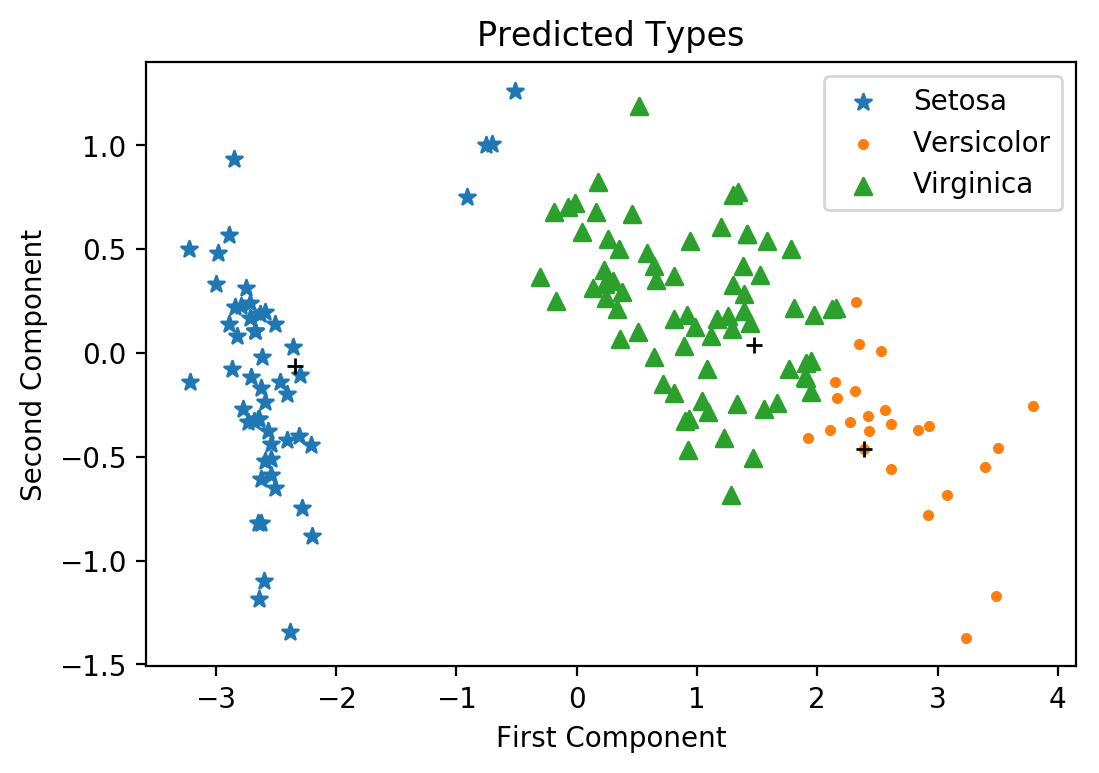

In [102]:
# Plot results
colors = ['g','c','r']
plt.title('Predicted Types')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.scatter(Y_hat[res==0,0],Y_hat[res==0,1],marker='*',label='Setosa')
plt.scatter(Y_hat[res==1,0],Y_hat[res==1,1],marker='.',label='Versicolor')
plt.scatter(Y_hat[res==2,0],Y_hat[res==2,1],marker='^',label='Virginica')
for i in range(kmean.means.shape[0]) :
    plt.plot(kmean.means[i,0],kmean.means[i,1],c='k',marker='+')
plt.legend()
plt.show()

## Problem 2

Modify `KMeansfit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

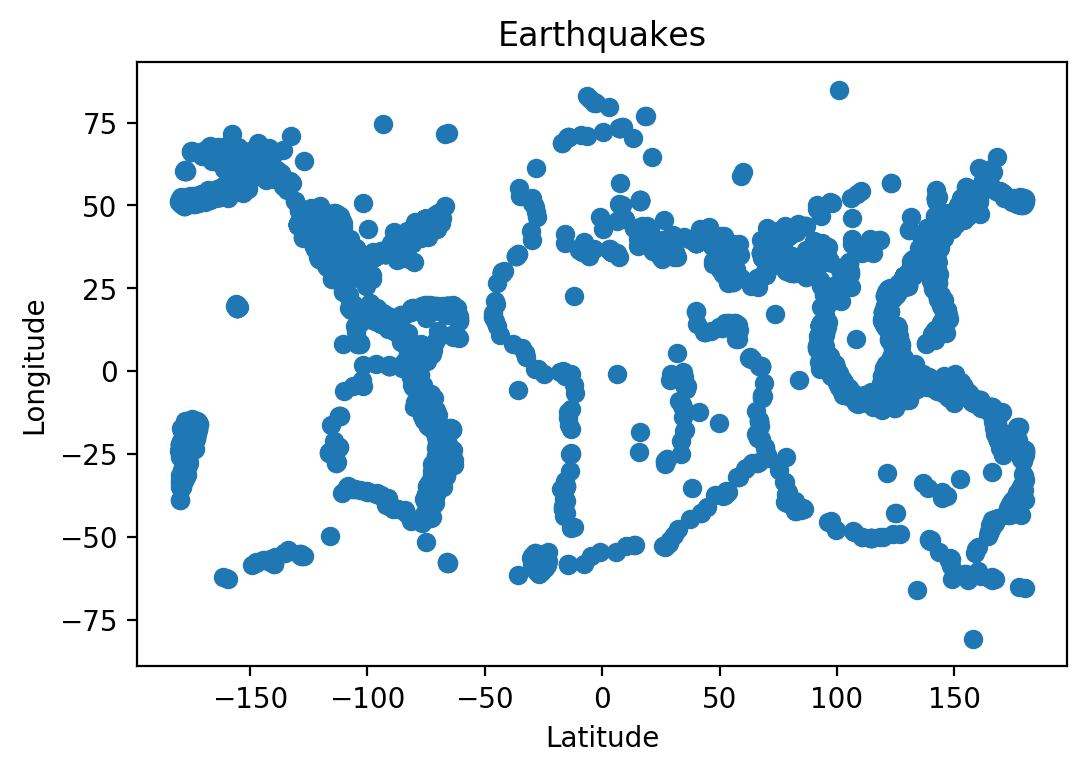

In [111]:
# Display earthquake data for quick view
earth = np.load('earthquake_coordinates.npy')
plt.scatter(earth[:,0],earth[:,1])
plt.title('Earthquakes')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [133]:
# Switch to radians
rad_coords = np.zeros_like(earth)
rad_coords[:,0] = np.pi/180*earth[:,0]
rad_coords[:,1] = np.pi/180*(90-earth[:,1])
# Switch to spherical
sphr_coords = np.zeros((rad_coords.shape[0],3))
sphr_coords[:,0] = np.ones_like(rad_coords[:,0])
sphr_coords[:,1] = rad_coords[:,1]
sphr_coords[:,2] = rad_coords[:,0]
# Switch to rectangular
rect_coords = np.zeros_like(sphr_coords)
rect_coords[:,0] = sphr_coords[:,0]*np.sin(sphr_coords[:,2])*np.cos(sphr_coords[:,1])
rect_coords[:,1] = sphr_coords[:,0]*np.sin(sphr_coords[:,2])*np.sin(sphr_coords[:,1])
rect_coords[:,2] = sphr_coords[:,0]*np.cos(sphr_coords[:,2])

In [148]:
# Run kmeans
earth_means = KMeans(n_clusters=15,normalize=True)
earth_means.fit(rect_coords)
res = earth_means.predict(rect_coords)
# Get means in rectangular coordinates
rect_means = earth_means.means
# Convert to spherical
sphr_means = np.zeros_like(rect_means)
sphr_means[:,0] = np.ones_like(rect_means[:,0])
sphr_means[:,1] = np.arctan2(rect_means[:,1],rect_means[:,0])
sphr_means[:,2] = np.arccos(rect_means[:,2])
# Convert to latitude-longitude
lat_long_means = np.zeros((sphr_means.shape[0],2))
for i in range(lat_long_means.shape[0]) :
    lat_long_means[i,1] = 90 - 180/np.pi*sphr_means[i,2]
    lat_long_means[i,0] = 180/np.pi*sphr_means[i,1]

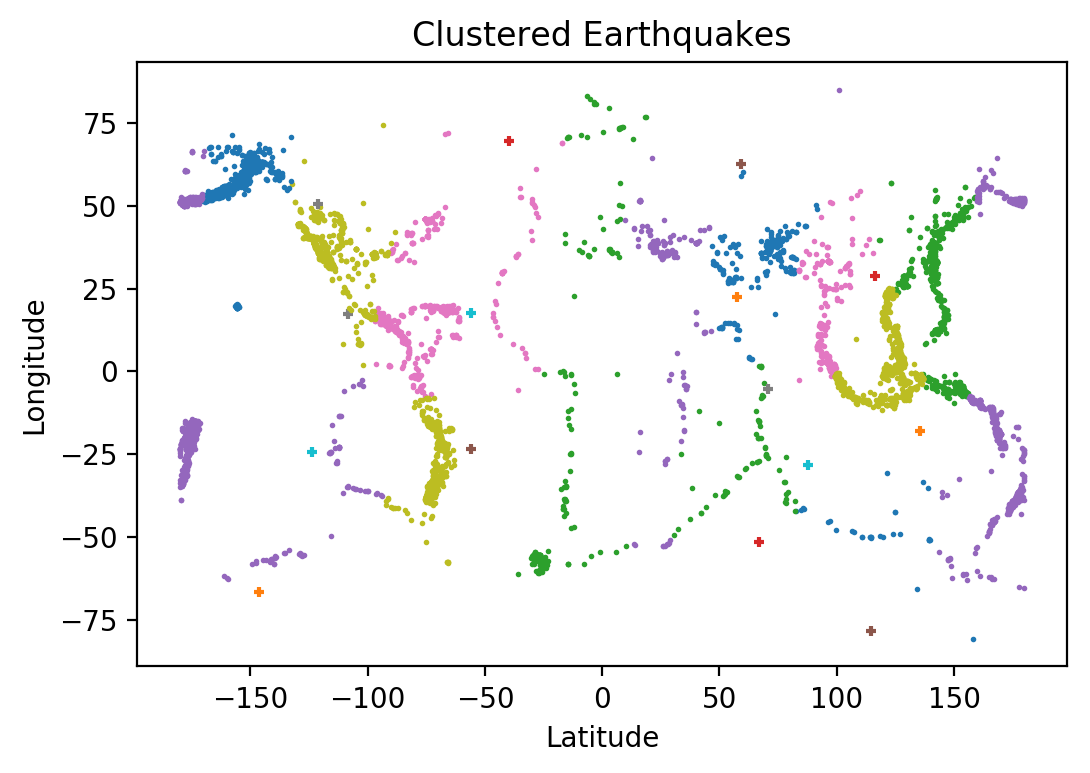

In [149]:
# Plot
for i in range(15) :
    plt.scatter(earth[res == i,0],earth[res == i,1],s=1)
    plt.scatter(lat_long_means[i,0],lat_long_means[i,1],marker='+',s=15)
plt.title('Clustered Earthquakes')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

## Problem 3

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

In [2]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    # Get shapes
    m,n,r = im.shape
    # Create new array for image in rgb space
    rgb_im = im.reshape(-1,r)
    # Get pixels for trainint
    pixels = np.random.randint(0,m*n,n_samples)
    X = rgb_im[pixels,:]
    # Run kmeans
    kmeans = rKMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    res = kmeans.predict(rgb_im)
    # Get cluster centers
    cents = kmeans.cluster_centers_
    # Create flattened image where each pixel is the color of it's center
    new_im = np.copy(rgb_im)
    for j in range(m*n) :
        new_im[j,:] = cents[res[j],:]
    # Final matrix (reshape it)
    return new_im.reshape(m,n,r)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


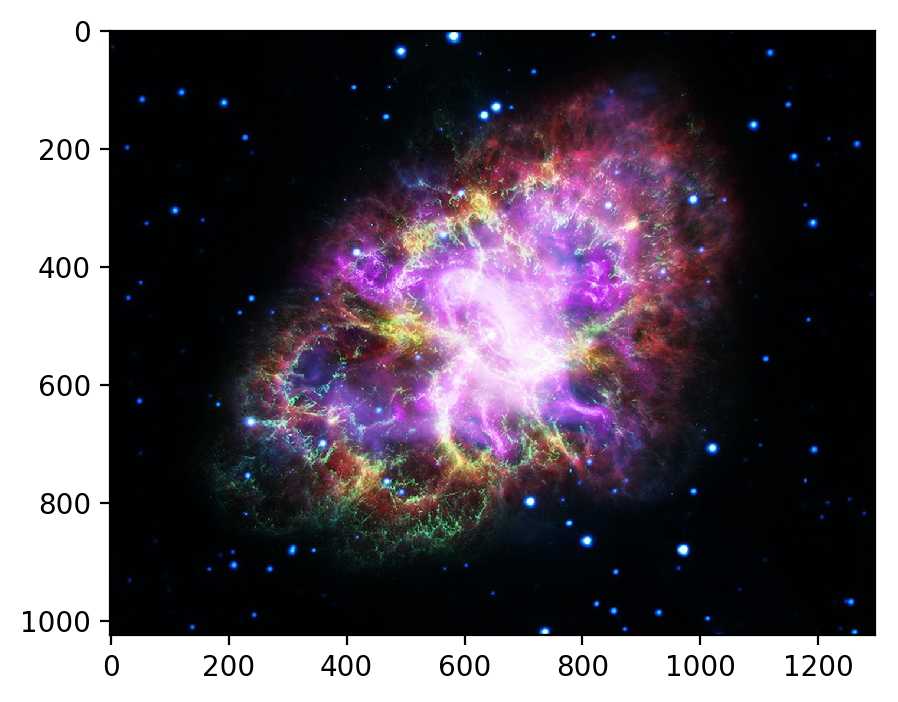

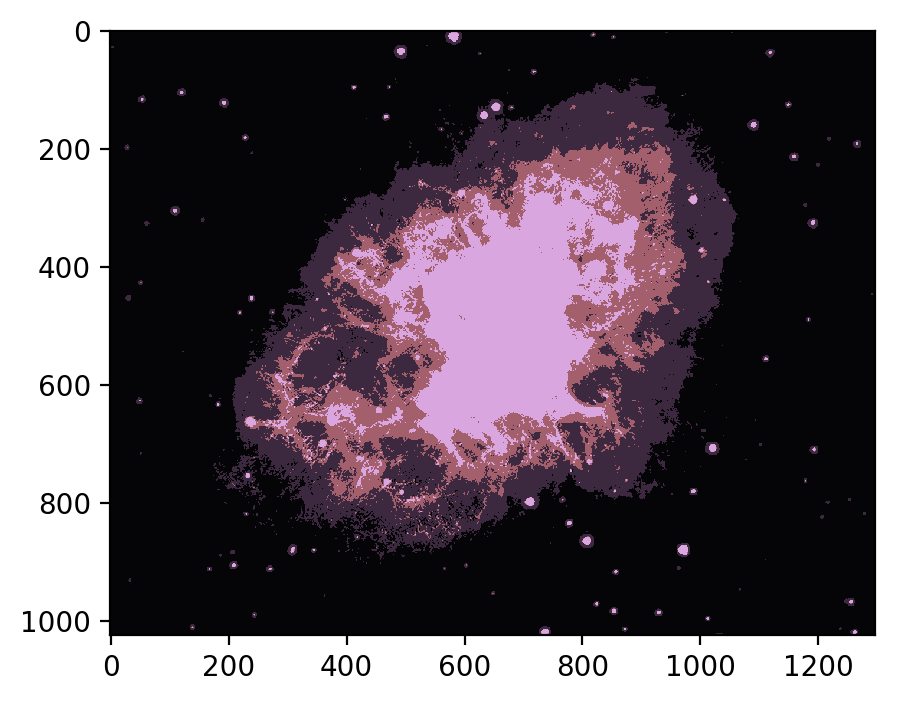

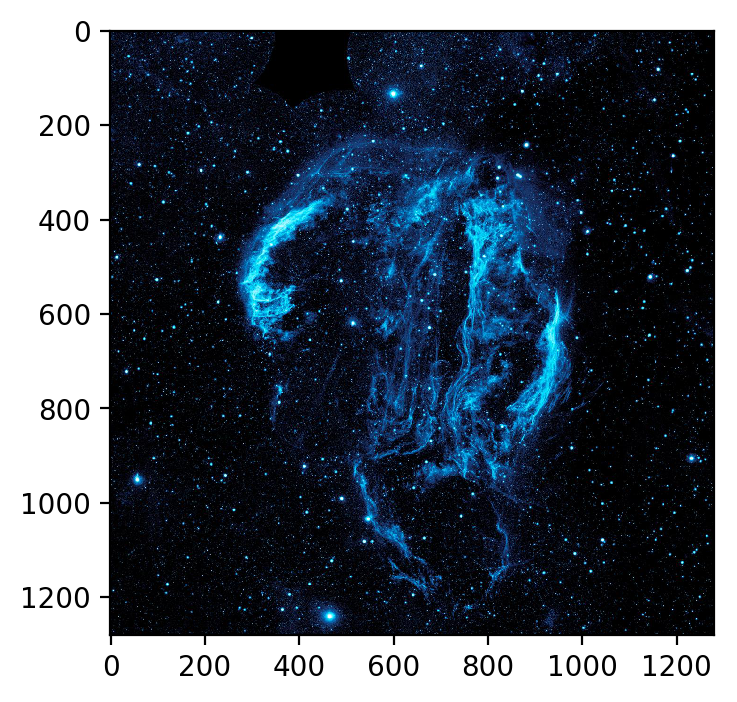

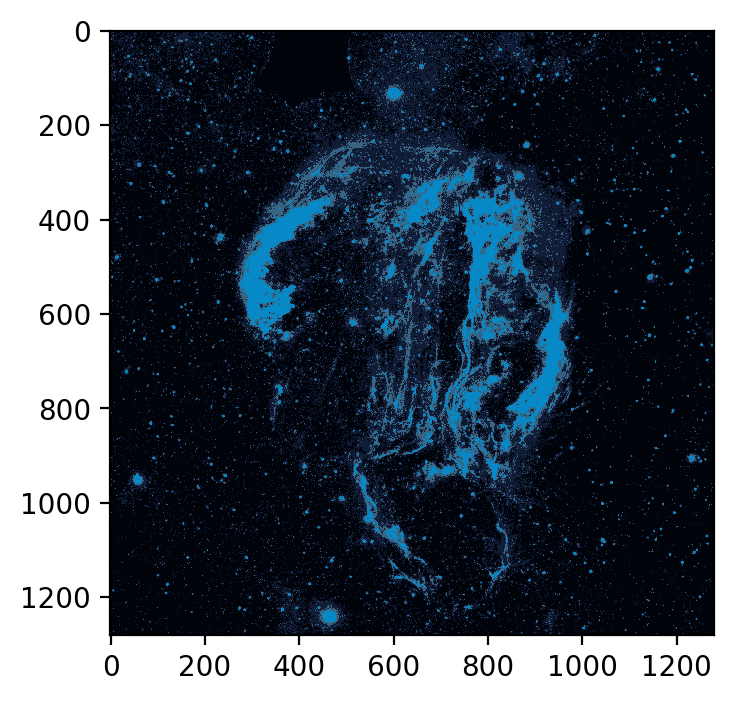

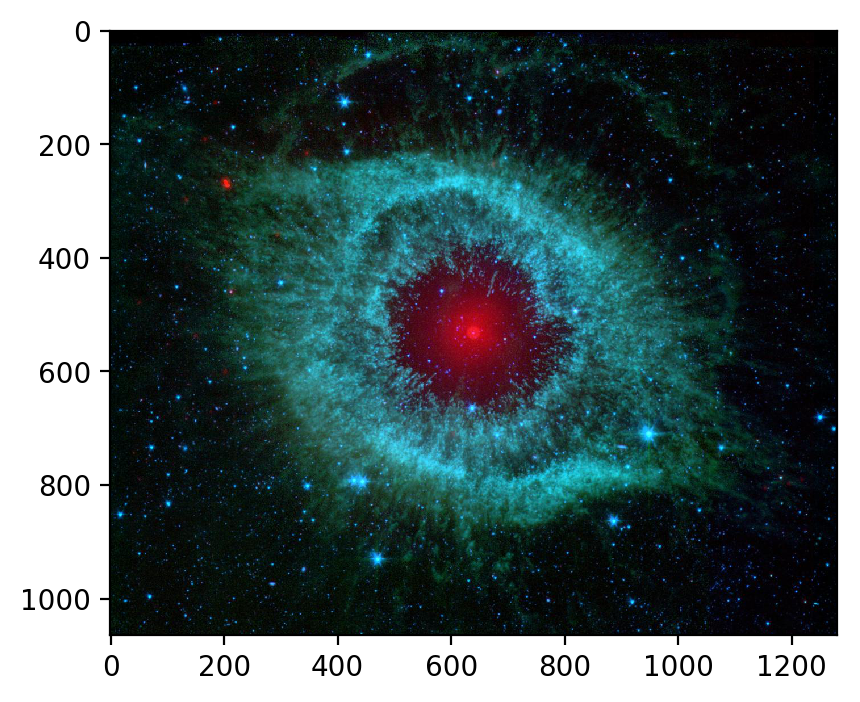

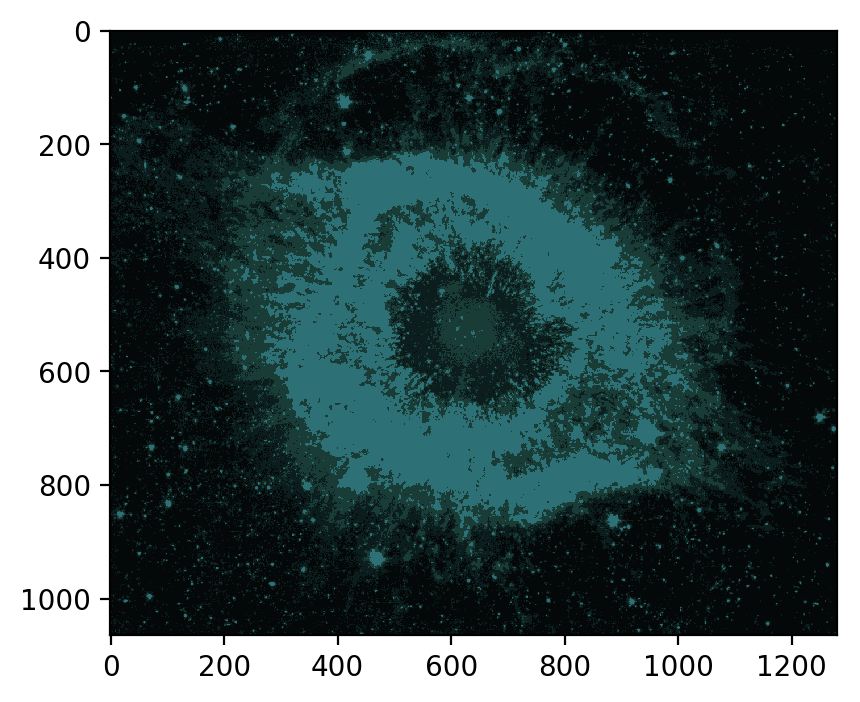

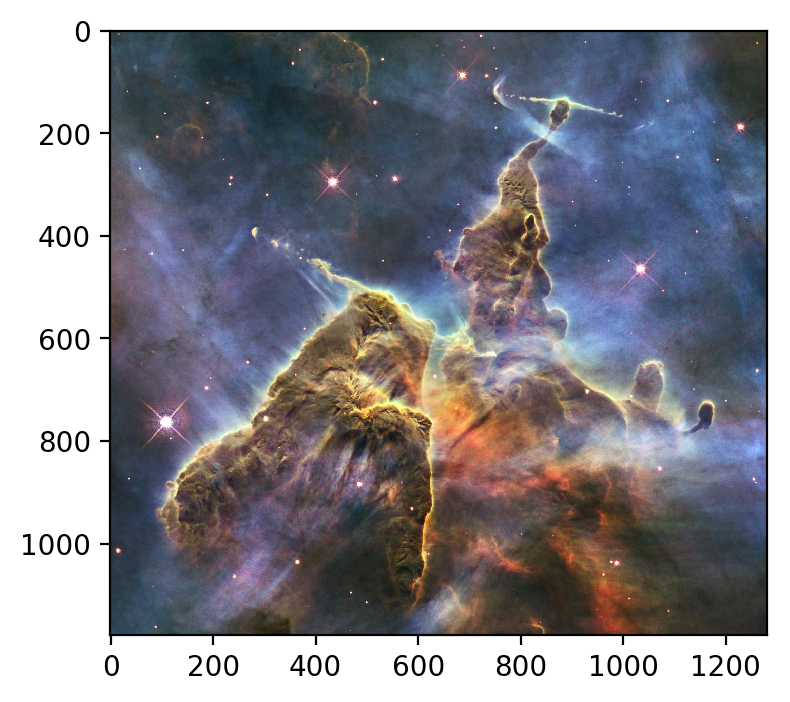

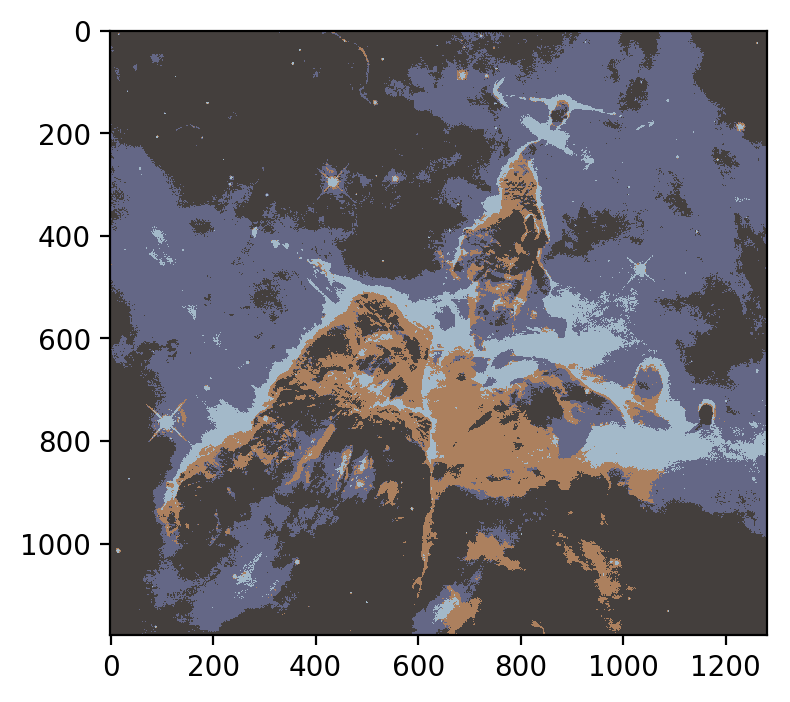

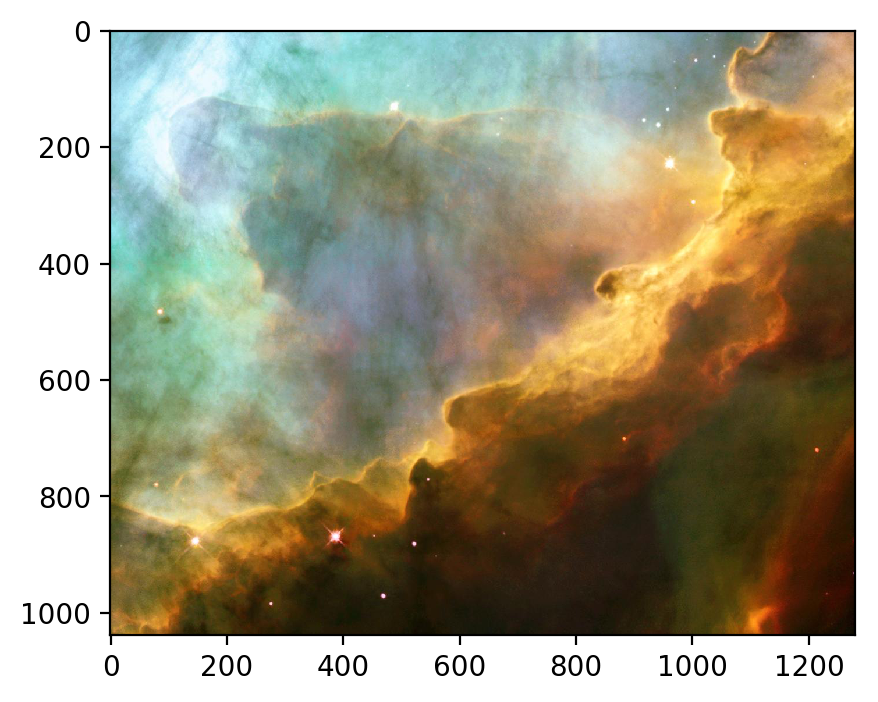

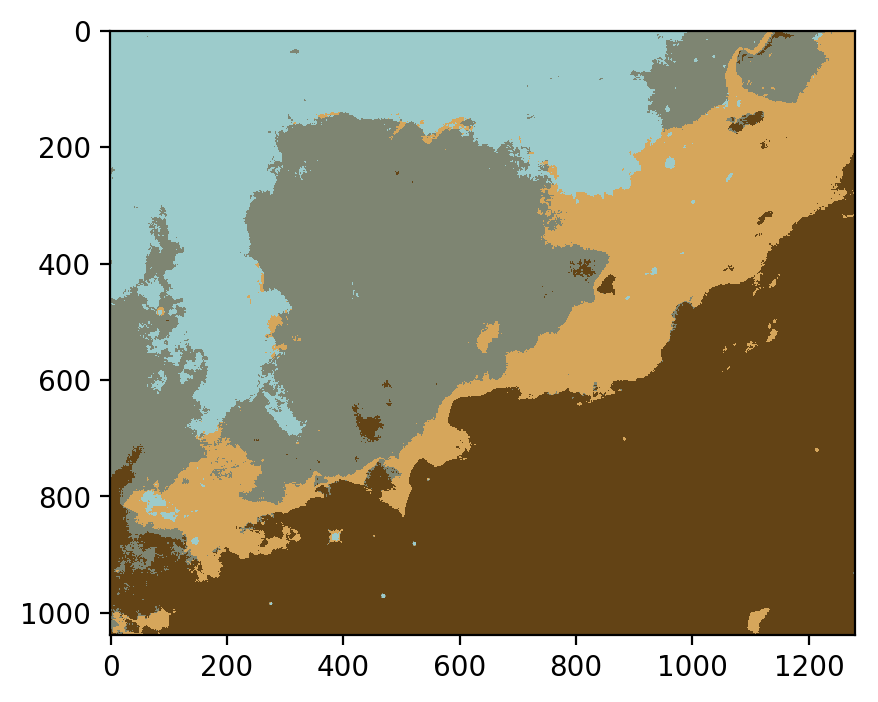

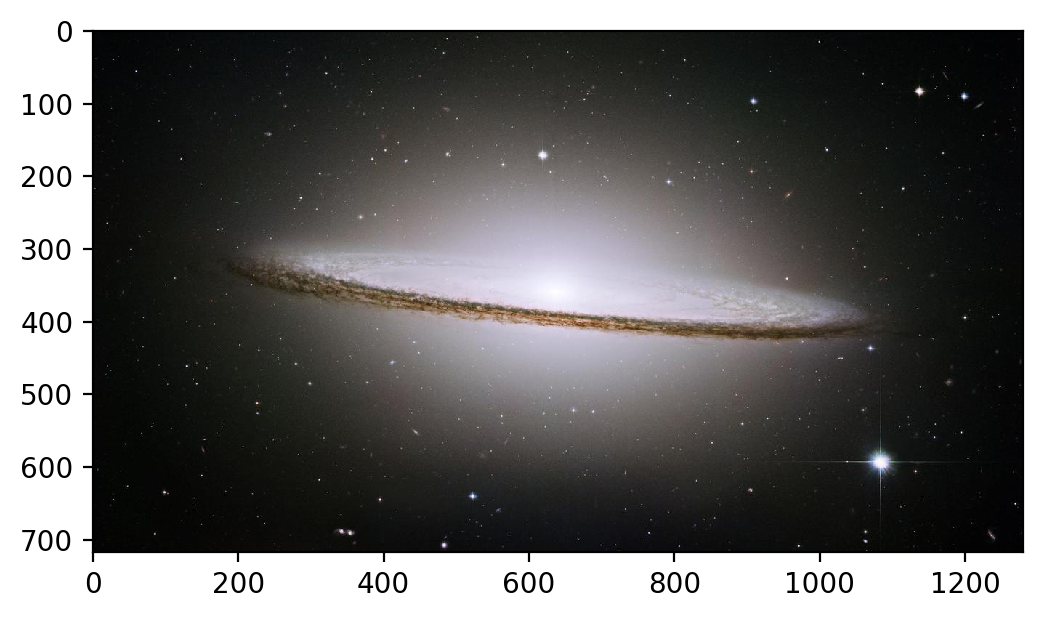

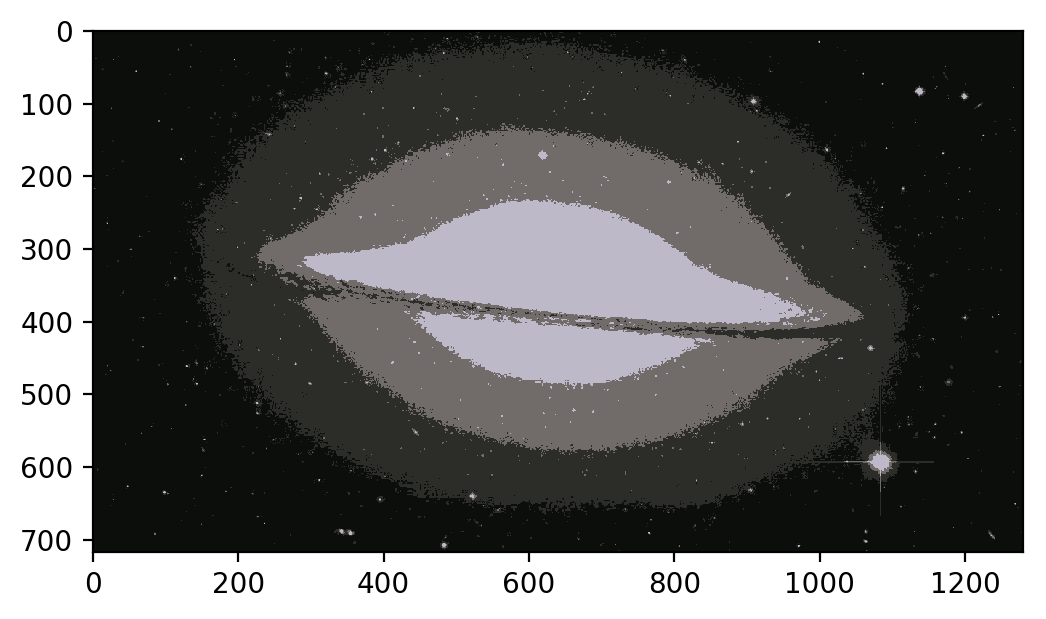

In [5]:
photos = []
# Go through all photos
for dir_path, direct, filename in os.walk('./nasa') :
    for file in filename :
        # Put them in a list
        photos.append(imread(str(dir_path)+'/'+str(file)))
# Display photo and quantized photo... Something went horrible wrong.
for photo in photos :
    imshow(photo)
    plt.show()
    imshow(quantize_image(photo))
    plt.show()